importing required packages

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split,KFold
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

mounting on google drive and opening the .mat files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Open the .mat file using h5py
# mat_file = h5py.File(r'C:\Users\hites\OneDrive\Desktop\machine learning\Brain Tumor Datasets-2\Brain Tumor Datasets\Dataset 3\Dataset 3\brainTumorDataPublic_1-766\1.mat', 'r')

# List all available dataset names in the file
# print(list(mat_file.keys()))

# Close the file
# mat_file.close()

# Define the directory containing the .mat files
directory = [r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1-766'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_767-1532'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1533-2298'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_2299-3064']

# Create a list to store the loaded data from all files
all_data = []
segmented_tumor_data=[]
# Iterate through the .mat files in the directory
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]
                patient_id = file['cjdata']['PID'][:]
                image_data = file['cjdata']['image'][:]
                tumor_border = file['cjdata']['tumorBorder'][:]
                tumor_mask = file['cjdata']['tumorMask'][:]
                segmented_tumor_data.append(np.where(tumor_mask == 1,image_data, 0))

                # Append the loaded data to the list
                all_data.append({
                    'label': label,
                    'patient_id': patient_id,
                    'image_data': image_data,
                    'tumor_border': tumor_border,
                    'tumor_mask': tumor_mask
                })
print(f'number of mri images: {len(all_data)}')

number of mri images: 3064


cheking unique patient id's

In [ ]:

d= {}
all_pid = []
d_new = {}
for i in range(0,3064):
  label = all_data[i]['label']
  patient_id = all_data[i]['patient_id']
  all_pid.append(patient_id)
  patient_id = np.array2string(patient_id)
  image_data = all_data[i]['image_data']
  tumor_border = all_data[i]['tumor_border']
  tumor_mask = all_data[i]['tumor_mask']
  if patient_id in d:
    d[patient_id] += 1
  else :
    d[patient_id] = 1
def convert_pid_to_string(pid_array):
  flatten_pid = pid_array.flatten()
  return ''.join(chr(int(num)) for num in flatten_pid)
converted_pid = []
for pid in all_pid:
  converted_pid.append(convert_pid_to_string(pid))
for pid in converted_pid:
  if pid in d_new:
    d_new[pid] += 1
  else :
    d_new[pid] = 1
print(f"unique patient id's:{len(d)}")


unique patient id's:233


IMAGE SEGMENTATION:
segmenting the tumor region using the tumor border and expanding this region
by a factor of 25% .As the tumor surrounding tissues also provide valuable tumor information

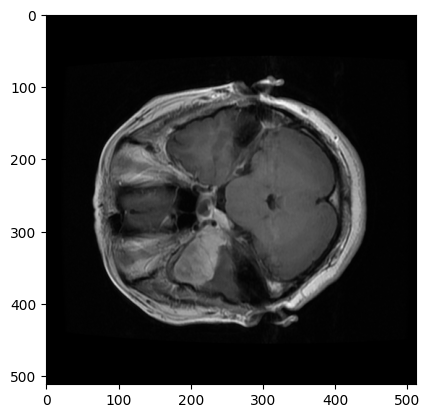

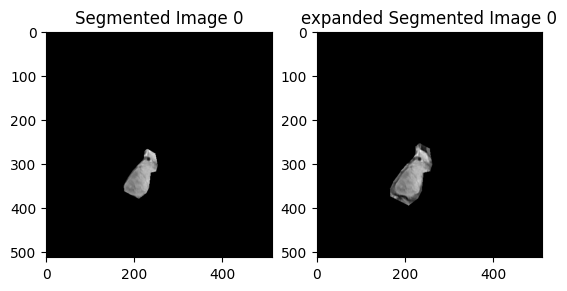

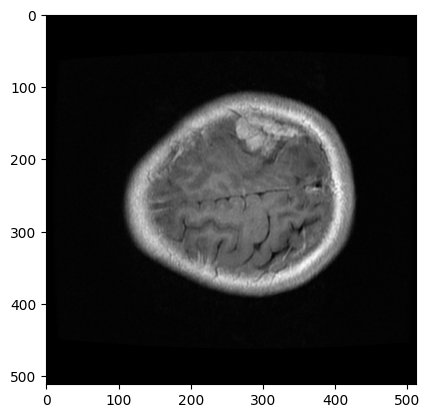

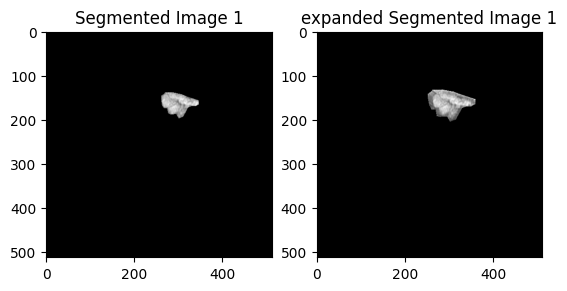

In [ ]:
expanding_factor = 0.25
expanded_segmented_tumor_data = []

for data in all_data:
    image_data = data['image_data']
    tumor_border = data['tumor_border'][0]

    test = np.ones_like(image_data)
    expanded_segmented_region = np.zeros_like(image_data)

    # Extracting x and y coordinates from tumor_border
    x_mean = np.mean([int(tumor_border[i]) for i in range(0, len(tumor_border), 2)])
    y_mean = np.mean([int(tumor_border[i + 1]) for i in range(0, len(tumor_border), 2)])
    expanded_x_coords = [int((int(tumor_border[i]) - x_mean)*expanding_factor+int(tumor_border[i]))for i in range(0, len(tumor_border), 2)]
    expanded_y_coords = [int((int(tumor_border[i+1]) - y_mean)*expanding_factor+int(tumor_border[i+1])) for i in range(0, len(tumor_border), 2)]
    # Creating a filled polygon based on the tumor border
    rr, cc = polygon(expanded_y_coords, expanded_x_coords)
    # Ensuring the indices are within image bounds
    rr = np.clip(rr, 0, image_data.shape[0] - 1)
    cc = np.clip(cc, 0, image_data.shape[1] - 1)
    # Setting the pixels within the polygon to the corresponding values from the original image
    expanded_segmented_region[rr, cc] = test[rr, cc]
    expanded_segmented_region = np.rot90(np.fliplr(expanded_segmented_region))

    expanded_segmented_tumor_data.append(np.where(expanded_segmented_region == 1,image_data, 0))

for i in range(2):
    image_data = all_data[i]['image_data']
    plt.imshow(image_data,cmap = 'gray')
    plt.show()
    expanded_segmented_image = expanded_segmented_tumor_data[i]
    plt.subplot(1,2,1)
    plt.imshow(segmented_tumor_data[i], cmap='gray')
    plt.title(f"Segmented Image {i}")
    plt.subplot(1,2,2)
    plt.imshow(expanded_segmented_image, cmap='gray')
    plt.title(f"expanded Segmented Image {i}")
    plt.show()


label mapping

In [ ]:

labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

print(len(tumor_data))
print(len(tumor_border))
print(len(expanded_segmented_tumor_data))

(3064,)
3064
3064
3064


data preprocessing segmented tumor data

1.  converting to tensors
2.  reshaping to 256x256
3.  train test split

In [ ]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
expanded_segmented_tumor_data = [data_transforms(image) for image in expanded_segmented_tumor_data]
expanded_segmented_tumor_data = [transforms.Resize((256,256))(image) for image in expanded_segmented_tumor_data]

mean = torch.zeros(1)
std = torch.zeros(1)

for image in expanded_segmented_tumor_data:
    mean += image.mean()
    std += image.std()

mean /= len(expanded_segmented_tumor_data)
std /= len(expanded_segmented_tumor_data)

# Squeeze to remove singleton dimensions
mean = mean.squeeze()
std = std.squeeze()

expanded_segmented_tumor_data = [transforms.Normalize(mean, std)(image) for image in expanded_segmented_tumor_data]

data_train,data_test,label_train,label_test = train_test_split(expanded_segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 16

2757 2757
307 307
torch.Size([1, 256, 256])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

vizualizing a batch of train_loader data

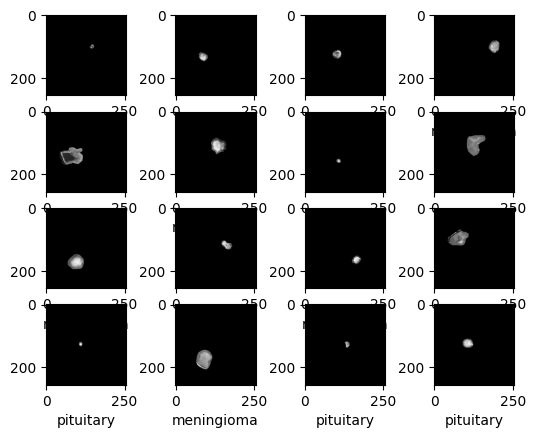

In [ ]:

images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(4,4,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

model training

In [ ]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

pretrained resnet18 model

In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.2MB/s]


Epoch 1/20
----------
train Loss: 0.8003 Acc: 0.6609
val Loss: 0.7521 Acc: 0.7166
Epoch 2/20
----------
train Loss: 0.6474 Acc: 0.7497
val Loss: 0.6791 Acc: 0.7524
Epoch 3/20
----------
train Loss: 0.6270 Acc: 0.7465
val Loss: 0.5975 Acc: 0.7622
Epoch 4/20
----------
train Loss: 0.6064 Acc: 0.7646
val Loss: 0.5711 Acc: 0.7785
Epoch 5/20
----------
train Loss: 0.5726 Acc: 0.7682
val Loss: 0.5443 Acc: 0.7883
Epoch 6/20
----------
train Loss: 0.5658 Acc: 0.7820
val Loss: 0.5600 Acc: 0.7850
Epoch 7/20
----------
train Loss: 0.5432 Acc: 0.7755
val Loss: 0.5772 Acc: 0.7915
Epoch 8/20
----------
train Loss: 0.5183 Acc: 0.8009
val Loss: 0.5257 Acc: 0.7980
Epoch 9/20
----------
train Loss: 0.5236 Acc: 0.8027
val Loss: 0.5366 Acc: 0.7948
Epoch 10/20
----------
train Loss: 0.5105 Acc: 0.8023
val Loss: 0.5306 Acc: 0.8013
Epoch 11/20
----------
train Loss: 0.5055 Acc: 0.8049
val Loss: 0.5349 Acc: 0.7915
Epoch 12/20
----------
train Loss: 0.5091 Acc: 0.8030
val Loss: 0.5547 Acc: 0.7818
Epoch 13/20
-

In [ ]:

def calculate_padding(input_size, kernel_size, stride):
    """
    Calculate the padding size to achieve 'same' padding in PyTorch.

    Args:
        input_size (int): Input size (height or width) of the feature map.
        kernel_size (int): Convolutional kernel size.
        stride (int): Convolutional stride.

    Returns:
        int: Padding size.
    """
    total_padding = max(0, (input_size - 1) * stride + kernel_size - input_size)
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    return left_padding, right_padding
print(calculate_padding(63,3,2))

(32, 32)


data preprocessing complete mri images

In [ ]:


data_transforms = transforms.Compose([transforms.ToTensor(),
                                      lambda x: x.to(torch.float32)])
tumor_data = [data_transforms(image) for image in tumor_data]
tumor_data = [transforms.Resize((256,256))(image) for image in tumor_data]
# Rotation_transforms = transforms.Compose([
#     transforms.RandomRotation(90),
# ])
# flip_transforms = transforms.Compose([
#     transforms.RandomRotation(90),
# ])
# original_images = tumor_data
# rotated_images = [Rotation_transforms(img) for img in tumor_data]
# flipped_images = [flip_transforms(img) for img in tumor_data]

# tumor_data = original_images + flipped_images
# labels = np.concatenate([labels, labels])
# print(len(labels))
# print(len(tumor_data))

mean = torch.zeros(1)
std = torch.zeros(1)

for image in tumor_data:
    mean += image.mean()
    std += image.std()

mean /= len(tumor_data)
std /= len(tumor_data)

# Squeeze to remove singleton dimensions
mean = mean.squeeze()
std = std.squeeze()

tumor_data = [transforms.Normalize(mean, std)(image) for image in tumor_data]
data_train,data_test,label_train,label_test = train_test_split(tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 16

2757 2757
307 307
torch.Size([1, 256, 256])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)


visualizing a batch of train_loder data

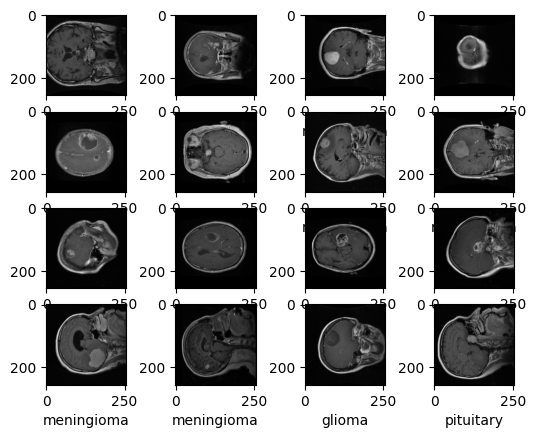

In [ ]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(4,4,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

training model : using early stopping

In [ ]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0
    early_stop_threshold = 1  # Adjusted early stopping threshold to 1 epoch

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if it has the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stop_counter = 0
            else:
                early_stop_counter += 1

        if early_stop_counter >= early_stop_threshold:
            print("Early stopping at epoch", epoch+1)
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

custom cnn architecture

In [ ]:


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=(129,130))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=(64,65))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 15 * 16, 1024)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 3)  # Output classes: meningioma, glioma, pituitary tumor
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass

        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.maxpool4(x)

        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x



initializing xavier (glorot) weights

> xavier glorot is a type of weights initialization proccess where it tries to initialize weight for improved convergence and performance n training .
It's goal is to initialize initial weights which can avoid vanishing and exploding gradient problem .
The Xavier initialization is applied to weights with the following formula:

Var
(
W
)
=
1/
fan_in
+
fan_out



where:

Var(W) is the variance of the weights.
fan_in is the number of input units in the weight tensor.
fan_out is the number of output units in the weight tensor.


optimizer : Adam starting learning rate of 0.0004 weight decay of 0.004 and decaying lr by a factor of 0.1 every 7 epochs

In [ ]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.xavier_uniform_(layer.weight)

# Instantiate the model
model_conv = CustomCNN()
model_conv.apply(initialize_weights)  # Apply Xavier (Glorot) weight initialization

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_conv = model_conv.to(device)

# Adjusted parameters based on provided conditions
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0004, weight_decay=0.004)  # Added weight decay for regularization

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


model_conv = train_model_with_early_stopping(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 1.0082 Acc: 0.5394
val Loss: 0.9334 Acc: 0.6743
Epoch 2/20
----------
train Loss: 0.9041 Acc: 0.6456
val Loss: 0.9657 Acc: 0.6124
Early stopping at epoch 2
Training complete in 0m 21s
Best val Acc: 0.674267


10 fold-cross-validation

In [ ]:
torch.manual_seed(42)

# Define the number of folds
num_folds = 10

# Lists to store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Define the confusion matrix
conf_matrix = np.zeros((3, 3))



def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d):
            nn.init.xavier_uniform_(layer.weight)


# Define your 10-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(data_loader['train'])))):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create new instances of the model for each fold
    model_conv = CustomCNN()
    model_conv.apply(initialize_weights)
    model_conv = model_conv.to(device)

    # Define new optimizer and scheduler for each fold
    optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0004, weight_decay=0.004)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    # Extract data for the current fold
    train_data_fold = [data_loader['train'].dataset[i] for i in train_indices]
    val_data_fold = [data_loader['train'].dataset[i] for i in val_indices]

    train_loader_fold = torch.utils.data.DataLoader(train_data_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = torch.utils.data.DataLoader(val_data_fold, batch_size=batch_size, shuffle=False)

    # Train the model using early stopping
    model_conv = train_model_with_early_stopping(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20)

    # Evaluate the model on the validation set
    model_conv.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader_fold:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics for the current fold
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Update the confusion matrix
    conf_matrix_fold = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    conf_matrix += conf_matrix_fold

    # Print metrics for the current fold
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix_fold)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)

# Calculate and print average metrics over all folds
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

print("\nAverage Metrics Over All Folds:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1_score:.4f}")


Fold 1/10
Epoch 1/20
----------
train Loss: 0.9913 Acc: 0.5557
val Loss: 0.9267 Acc: 0.6515
Epoch 2/20
----------
train Loss: 0.8835 Acc: 0.6594
val Loss: 0.9681 Acc: 0.6091
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.651466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2/10
Epoch 1/20
----------
train Loss: 0.9069 Acc: 0.6373
val Loss: 0.9538 Acc: 0.6319
Epoch 2/20
----------
train Loss: 0.9047 Acc: 0.6442
val Loss: 0.9416 Acc: 0.6450
Epoch 3/20
----------
train Loss: 0.8911 Acc: 0.6565
val Loss: 0.8945 Acc: 0.7231
Epoch 4/20
----------
train Loss: 0.8592 Acc: 0.6866
val Loss: 0.8867 Acc: 0.7296
Epoch 5/20
----------
train Loss: 0.8437 Acc: 0.7018
val Loss: 0.9459 Acc: 0.6189
Early stopping at epoch 5
Training complete in 0m 29s
Best val Acc: 0.729642
Fold 3/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 0.9577 Acc: 0.5919
val Loss: 0.9904 Acc: 0.6026
Epoch 2/20
----------
train Loss: 0.9500 Acc: 0.6010
val Loss: 0.9932 Acc: 0.6026
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.602606
Fold 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 1.0097 Acc: 0.5415
val Loss: 0.9910 Acc: 0.6026
Epoch 2/20
----------
train Loss: 0.9486 Acc: 0.6032
val Loss: 0.9894 Acc: 0.6026
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.602606
Fold 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 0.9935 Acc: 0.5517
val Loss: 0.9705 Acc: 0.6059
Epoch 2/20
----------
train Loss: 1.1278 Acc: 0.4204
val Loss: 1.0164 Acc: 0.6124
Epoch 3/20
----------
train Loss: 0.9256 Acc: 0.6253
val Loss: 0.9609 Acc: 0.6221
Epoch 4/20
----------
train Loss: 0.9057 Acc: 0.6453
val Loss: 0.9544 Acc: 0.6319
Epoch 5/20
----------
train Loss: 0.8984 Acc: 0.6529
val Loss: 0.9467 Acc: 0.6287
Early stopping at epoch 5
Training complete in 0m 30s
Best val Acc: 0.631922
Fold 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 1.0763 Acc: 0.4748
val Loss: 1.2353 Acc: 0.3192
Epoch 2/20
----------
train Loss: 1.2497 Acc: 0.3018
val Loss: 1.1697 Acc: 0.3192
Early stopping at epoch 2
Training complete in 0m 14s
Best val Acc: 0.319218
Fold 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 0.9993 Acc: 0.5528
val Loss: 0.9983 Acc: 0.6026
Epoch 2/20
----------
train Loss: 1.0298 Acc: 0.5187
val Loss: 1.0623 Acc: 0.4365
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.602606
Fold 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 0.9490 Acc: 0.5999
val Loss: 0.9433 Acc: 0.6156
Epoch 2/20
----------
train Loss: 0.9443 Acc: 0.6032
val Loss: 0.9645 Acc: 0.6026
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.615635
Fold 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 1.0965 Acc: 0.4516
val Loss: 1.0043 Acc: 0.5961
Epoch 2/20
----------
train Loss: 0.9651 Acc: 0.5854
val Loss: 1.0054 Acc: 0.6026
Epoch 3/20
----------
train Loss: 0.9486 Acc: 0.6025
val Loss: 1.0083 Acc: 0.6026
Early stopping at epoch 3
Training complete in 0m 18s
Best val Acc: 0.602606
Fold 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
----------
train Loss: 0.9146 Acc: 0.6260
val Loss: 0.9698 Acc: 0.6808
Epoch 2/20
----------
train Loss: 0.8567 Acc: 0.6852
val Loss: 0.9405 Acc: 0.6417
Early stopping at epoch 2
Training complete in 0m 12s
Best val Acc: 0.680782

Average Metrics Over All Folds:
Average Accuracy: 0.6301
Average Precision: 0.5036
Average Recall: 0.6301
Average F1 Score: 0.5273


plotting confusion matrix

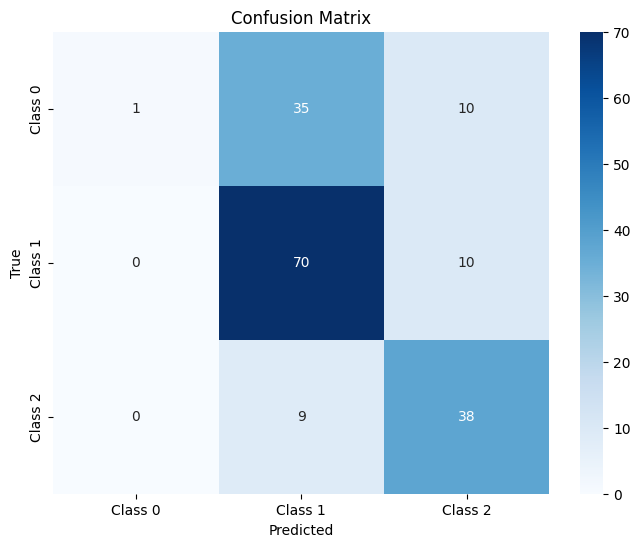

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()